In [182]:
import gzip
import pandas as pd
import numpy as np
from io import StringIO
from matplotlib import pyplot as plt

def readData(filename):
    with gzip.open(filename, 'rb') as f:
        content = f.read().decode('utf-8')
    df = pd.read_csv(StringIO(content))
    return df

def getDurations(df):
    values = []
    timestamp = []
    prev_timestamp = 0
    for index, row in df.iterrows():
        if(row['metric_name'] == "http_req_duration" and row['timestamp'] != prev_timestamp):
            values.append(row['metric_value'])
            timestamp.append(row['timestamp'] - df['timestamp'].iloc[0])
            prev_timestamp = row['timestamp']
    return values, timestamp

def compare(mono, micro, y_low, y_high):
    plt.plot(mono[1], mono[0], label='Monolith', color='blue', linestyle='-')
    plt.plot(micro[1], micro[0], label='Microservice', color='red', linestyle='-')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.title('Request duration')
    plt.ylim(y_low, y_high)
    plt.grid(True)
    plt.legend()
    plt.show()
    
def findSampleMedian(collection):
    medians = []
    for i in range(len(collection)):
        medians.append(np.median(getDurations(collection[i])))
    median = np.median(medians)
    median = sorted(medians)[int(len(medians)/2)]
    index = medians.index(median)
    return collection[index]

def findSampleMean(collection):
    averages = []
    for i in range(len(collection)):
        averages.append(np.mean(getDurations(collection[i])))
    median = np.median(averages)
    median = sorted(averages)[int(len(averages)/2)]
    index = averages.index(median)
    return collection[index]

def soft(values, sec):
    mean_dur = []
    mean_time = []
    timestamp = values[1][0]-sec
    for i in range(int((len(values[0])-sec)/sec)):
        if ((values[1][i] - values[1][0]) > timestamp + 0.5):
            mean_dur.append(np.mean(values[0][i*sec:i*sec+sec]))
            mean_time.append(values[1][i*sec])
            timestamp = values[1][i]
    return mean_dur, mean_time

def reqRate(sample):
    count = 1
    current_timestamp = 0
    rate_at_time = [[], []]
    for index, row in sample.iterrows():
        if row['metric_name'] == 'http_reqs':
            timestamp = row['timestamp'] - sample['timestamp'][0]
            if current_timestamp is None:
                current_timestamp = timestamp
            if timestamp == current_timestamp:
                count += 1
            else:
                rate_at_time[0].append(count)
                rate_at_time[1].append(current_timestamp)
                count = 1
                current_timestamp = row['timestamp'] - sample['timestamp'][0]
    if count > 0:
        rate_at_time[0].append(count)
        rate_at_time[1].append(current_timestamp)
    return rate_at_time

def median_req_rate(rates):
    req_rates = []
    for i in range(len(rates)):
        req_rates.append( [sum(reqRate(rates[i])[0])/reqRate(rates[i])[1][-1], rates[i]]  )
                   
    mono_ramp = sorted(mono_rates, key=lambda x: x[0])[int(len(mono_rates)/2)]
    return mono_ramp

In [123]:
mono_baseline_1 = readData('baseline/mono_1_baseline_1.gz')
mono_baseline_2 = readData('baseline/mono_1_baseline_2.gz')
mono_baseline_3 = readData('baseline/mono_1_baseline_3.gz')
mono_baseline_4 = readData('baseline/mono_1_baseline_4.gz')
mono_baseline_5 = readData('baseline/mono_1_baseline_5.gz')
mono_baseline_list = [mono_baseline_1, mono_baseline_2, mono_baseline_3, mono_baseline_4, mono_baseline_5]

micro_baseline_1 = readData('baseline/micro_1_baseline_1.gz')
micro_baseline_2 = readData('baseline/micro_1_baseline_2.gz')
micro_baseline_3 = readData('baseline/micro_1_baseline_3.gz')
micro_baseline_4 = readData('baseline/micro_1_baseline_4.gz')
micro_baseline_5 = readData('baseline/micro_1_baseline_5.gz')
micro_baseline_list = [micro_baseline_1, micro_baseline_2, micro_baseline_3, micro_baseline_4, micro_baseline_5]

mono_ramp_1 = pd.read_csv('ramp/mono_1_ramp_1.csv')
mono_ramp_2 = pd.read_csv('ramp/mono_1_ramp_2.csv')
mono_ramp_3 = pd.read_csv('ramp/mono_1_ramp_3.csv')
mono_ramp_4 = pd.read_csv('ramp/mono_1_ramp_4.csv')
mono_ramp_5 = pd.read_csv('ramp/mono_1_ramp_5.csv')
mono_ramp_list = [mono_ramp_1, mono_ramp_2, mono_ramp_3, mono_ramp_4, mono_ramp_5]

micro_ramp_1 = pd.read_csv('ramp/micro_1_ramp_1.csv')
micro_ramp_2 = pd.read_csv('ramp/micro_1_ramp_2.csv')
micro_ramp_3 = pd.read_csv('ramp/micro_1_ramp_3.csv')
micro_ramp_4 = pd.read_csv('ramp/micro_1_ramp_4.csv')
micro_ramp_5 = pd.read_csv('ramp/micro_1_ramp_5.csv')
micro_ramp_list = [micro_ramp_1, micro_ramp_2, micro_ramp_3, micro_ramp_4, micro_ramp_5]

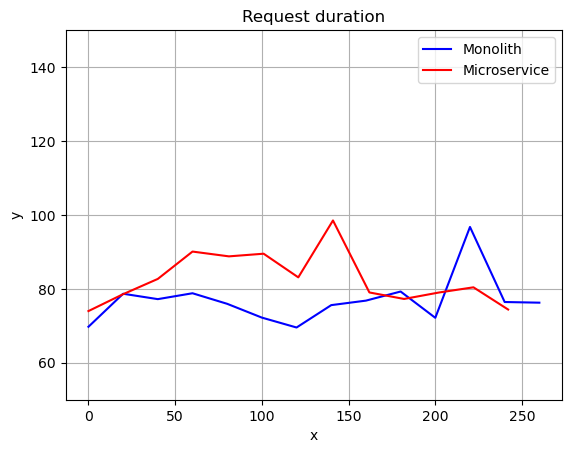

In [124]:
# Compare baseline results

mono_baseline_true = getDurations(findSampleMedian(mono_baseline_list))
micro_baseline_true = getDurations(findSampleMedian(micro_baseline_list))

mono_baseline_10sec = soft(mono_baseline_true, 20)
micro_baseline_10sec = soft(micro_baseline_true, 20)

compare(mono_baseline_10sec, micro_baseline_10sec, 50, 150)

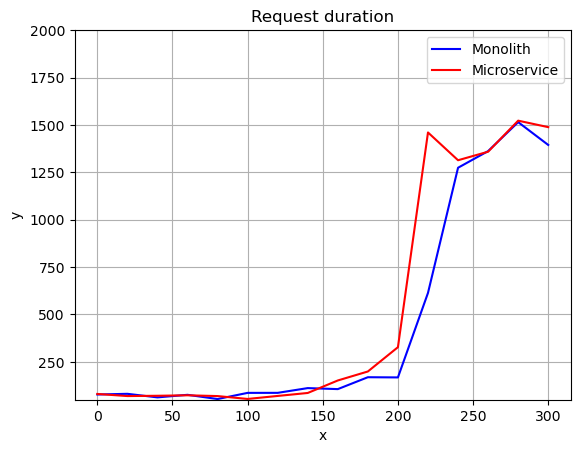

In [125]:
# Compare ramp test results

#mono_ramp_true = getDurations(median_req_rate(mono_ramp_list))
#micro_ramp_true = getDurations(median_req_rate(micro_ramp_list))

mono_ramp_true = getDurations(findSampleMean(mono_ramp_list))
micro_ramp_true = getDurations(findSampleMean(micro_ramp_list))

mono_ramp_10sec = soft(mono_ramp_true, 20)
micro_ramp_10sec = soft(micro_ramp_true, 20)

compare(mono_ramp_10sec, micro_ramp_10sec, 50, 2000)

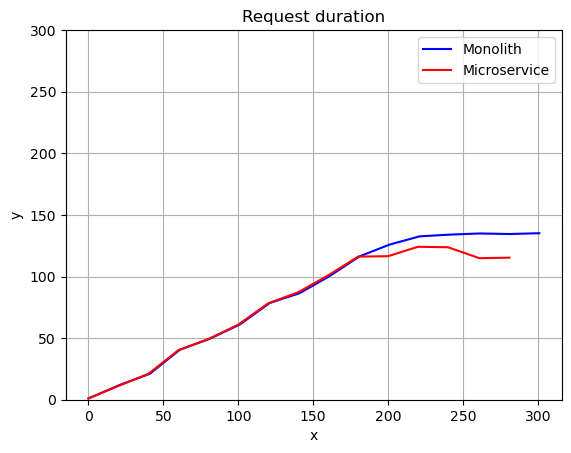

In [126]:
# Compare request rates
compare(soft(reqRate(mono_ramp_true), 20), soft(reqRate(micro_ramp_true), 20), y_low=0, y_high=300)